# Phase Retrieval

Following Hanser et. al.,

## Notes

Noise will quickly corrupt the phase retrieval. The background has to be suppressed well.

The phase of the mean of a set of complex numbers is equivalent to the weighted average of the phases of the set where the weights are the magnitudes, i.e.
\begin{align}
    z &= x + iy = r e^{i\theta}\\
    \langle z \rangle &= \langle x \rangle + i \langle y \rangle = \bar{r} e^{i\bar{\theta}}
\end{align}
where
\begin{align}
    \bar{r} &= \sqrt{\langle x \rangle^2 + \langle y \rangle^2}\\
    \bar{\theta} &= \arctan\frac{\langle y \rangle}{\langle x \rangle}
\end{align}
The conjecture is that
\begin{equation}
    \bar{\theta} = \frac{\langle r\theta \rangle}{\langle r\rangle}
\end{equation}

In [1]:
%load_ext autoreload
%autoreload 2
import os
import tqdm
from skimage.external import tifffile as tif
%pylab inline
from psfotf import *

from dphutils import scale, fft_pad
from skimage.restoration import unwrap_phase
from dphplotting import mip, slice_plot, display_grid

Populating the interactive namespace from numpy and matplotlib


In [2]:
test_data = tif.imread("../fixtures/psf_wl520nm_z300nm_x130nm_na0.85_n1.0.tif")
params = dict(
    size = test_data.shape[-1],
    zsize = test_data.shape[0],
    na = 0.85,
    res = 130,
    zres = 300,
    wl = 520,
    ni = 1.0,
    vec_corr="none",
    condition="none"
)

C:\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1398: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [3]:
test_data = tif.imread("../fixtures/BIL113_zstack_z300nm_current.tif")
params = dict(
    size = test_data.shape[-1],
    zsize = test_data.shape[0],
    na = 1.1,
    res = 90.5,
    zres = 300,
    wl = 605,
    ni = 1.33,
    vec_corr="none",
    condition="none"
)

C:\Anaconda3\lib\site-packages\skimage\external\tifffile\tifffile.py:1398: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [26]:
psf._pupil.shape

(21, 128, 128)

(21, 128, 128)


(<matplotlib.figure.Figure at 0x169594c5c18>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001695C1A8080>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001695AC59080>], dtype=object))

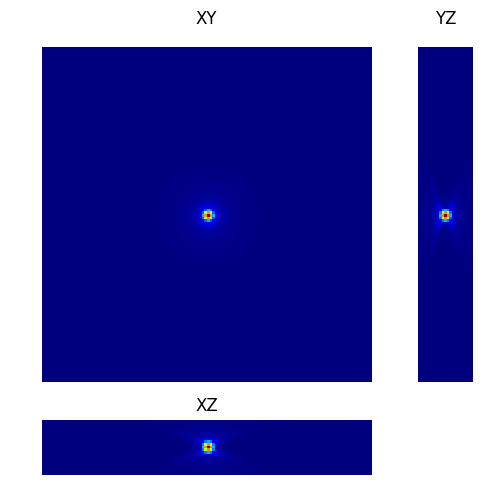

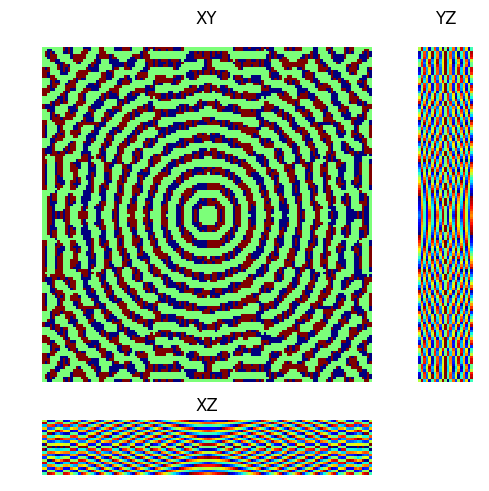

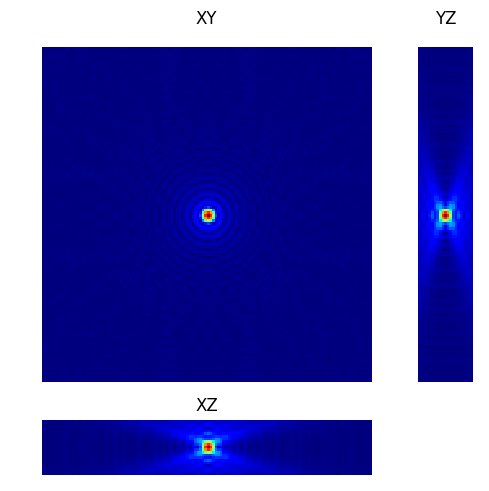

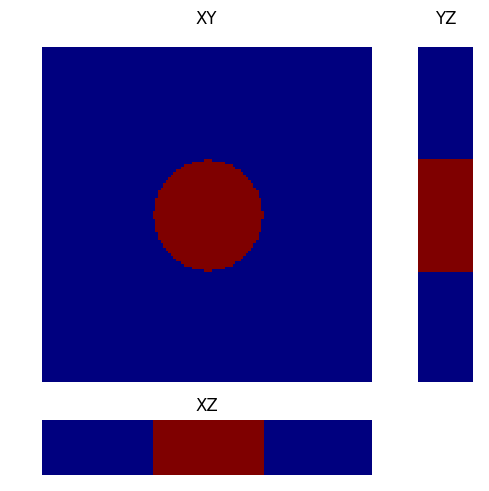

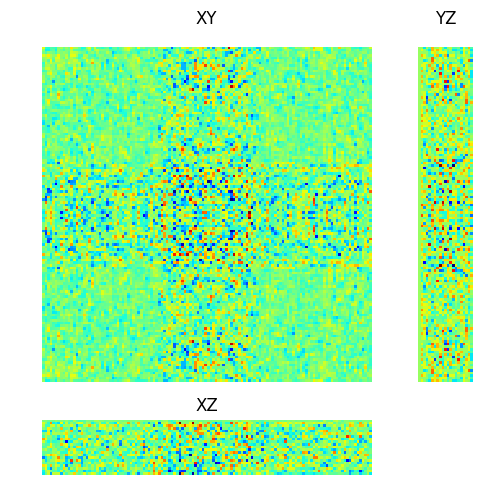

In [29]:
# some diagnostics to check the behaviour is correct
psf = HanserPSF(**params)
mip(psf.PSFi)
print(psf._pupil.shape)
slice_plot(angle(psf.PSFa[0]))
slice_plot(abs(psf.PSFa[0]))
new_pupils = fftn(fftshift(psf.PSFa[0], axes=(1,2)), axes=(1,2)) / psf._calc_defocus()
slice_plot(ifftshift(new_pupils).real)
slice_plot(ifftshift(new_pupils).imag)

In [4]:
def center_data(data):
    """Utility to center the data
    
    Parameters
    ----------
    data : ndarray
        Array of data points
        
    Returns
    -------
    centered_data : ndarray same shape as data
        data with max value at the central location of the array
    """
    # copy data
    centered_data = data.copy()
    # extract shape and max location
    data_shape = data.shape
    max_loc = unravel_index(data.argmax(), data_shape)
    # iterate through dimensions and roll data to the right place
    for i, (x0, nx) in enumerate(zip(max_loc, data_shape)):
#         print("x0 = {}, nx = {}".format(x0, nx))
        centered_data = roll(centered_data, (nx + 1)//2 - x0, i)
    return centered_data

In [5]:
def remove_bg(data, multiplier=1.5):
    """Utility that measures mode of data and subtracts it"""
    mode = np.bincount(data.astype(int).ravel()).argmax()
    return data - multiplier * mode

In [6]:
def psqrt(data):
    """Take the positive square root of data, any negative values will be set to zero."""
    sdata = zeros_like(data)
    sdata[data > 0] =sqrt(data[data > 0])
    return sdata

In [35]:
def retrieve_phase_iter(mag, psf, pupil=None):
    """The phase retrieval step"""
    # generate pupil if first iter
    if pupil is None:
        pupil = psf._gen_pupil()
    # generate the psf
    psf._gen_psf(pupil)
    # keep phase
    phase = angle(psf.PSFa.squeeze())
    # replace magnitude with experimentally measured mag
    new_psf = mag * exp(1j * phase)
    # generate the new pupils
    new_pupils = fftn(fftshift(new_psf, axes=(1,2)), axes=(1,2))
    # undo defocus and take the mean and mask off values outside passband
    # might want to unwrap phase before taking mean
    new_pupil = psf._gen_pupil() * (new_pupils / psf._calc_defocus()).mean(0)
    # if phase only discard magnitude info, the following avoids divide by zero
    return new_pupil, new_pupils

In [36]:
from collections import namedtuple

In [37]:
PhaseRetrievalResult = namedtuple("PhaseRetrievalResult", ["mag", "phase", "mse", "pupil_diff", "mse_diff"])

In [43]:
def retrieve_phase(data, params, max_iters=200, pupil_tol=1e-10, mse_tol=np.nan, phase_only=False):
    """Code that actually runs the phase retrieval
    
    Parameters
    ----------
    data : ndarray (3 dim)
        The experimentally measured data
    params : dict
        Parameters to pass to HanserPSF, size and zsize will be automatically updated from data.shape
    max_iters : int
        The maximum number of iterations to run, default is 200
    pupil_tol : float
        the tolerance in percent change in change in pupil, default is 1e-8
    mse_tol : float
        the tolerance in percent change for the mean squared error between data and simulated data"""
    
    # assume that data prep has been handled outside function
    mag = psqrt(data)
    params = params.copy()
    params.update(dict(zsize = mag.shape[0], size = mag.shape[-1]))
    model = HanserPSF(**params)
    old_mse = ((data - model.PSFi) ** 2).mean()
    mse = [old_mse]
    mse_diff = zeros(max_iters)
    old_pupil = model._gen_pupil()
    pupil_diff = zeros(max_iters)
    mask = ((old_pupil.real))
    for i in range(max_iters):
        new_pupil, pupils = retrieve_phase_iter(mag, model, old_pupil)
        if phase_only:
            new_pupil = exp(1j * angle(new_pupil)) * mask
        # this shouldn't be necessary, need to update HanserPSF code
        new_mse = ((data - model.PSFi) ** 2).mean()
        mse.append(new_mse)
        mse_diff[i] = abs(old_mse - new_mse) / old_mse
        old_mse = new_mse
        pupil_diff[i] = (abs(old_pupil - new_pupil)**2).mean()/(abs(old_pupil)**2).mean()
        old_pupil = new_pupil
        if pupil_diff[i] < pupil_tol or mse_diff[i] < mse_tol:
            break
            
    pupil_diff = pupil_diff[:i+1]
    mse_diff = mse_diff[:i+1]
    mask = ifftshift(mask)
    phase = unwrap_phase(ifftshift(angle(old_pupil))) * mask
    magnitude = ifftshift(abs(old_pupil)) * mask
    return PhaseRetrievalResult(magnitude, phase, array(mse), pupil_diff, mse_diff)

In [44]:
junk = remove_bg(center_data(test_data))
# mag = prep_data(test_data)
result = retrieve_phase(junk, params, 25, phase_only=True)

25

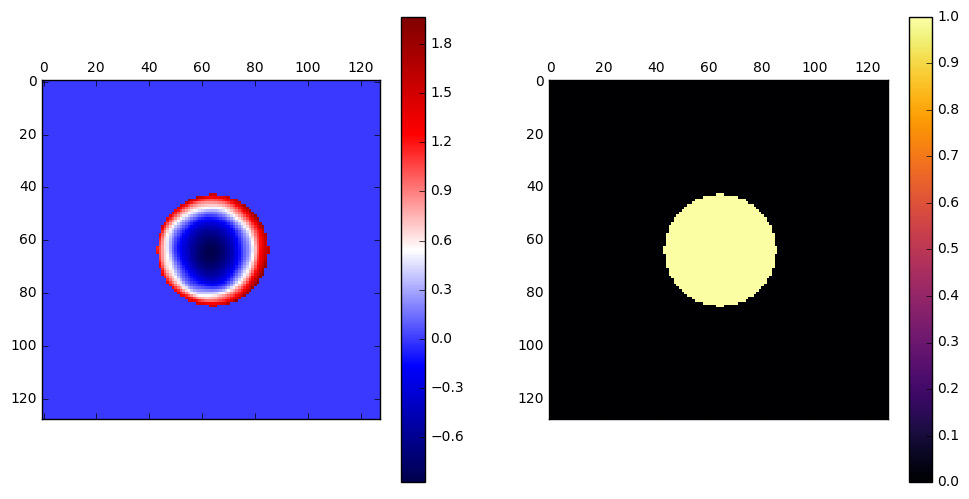

In [45]:
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(result.phase, cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(result.mag, cmap="inferno")
colorbar(img2, ax=axs[1])
# figure()
# plot(abs(result.mse[:-1] - result.mse[1:])/result.mse[:-1])
# plot(result.mse_diff)
# figure()
# plot(result.pupil_diff[10:])
len(result.pupil_diff)

In [47]:
from psfotf.phaseretrieval import retrieve_phase as retrieve_phase2

25

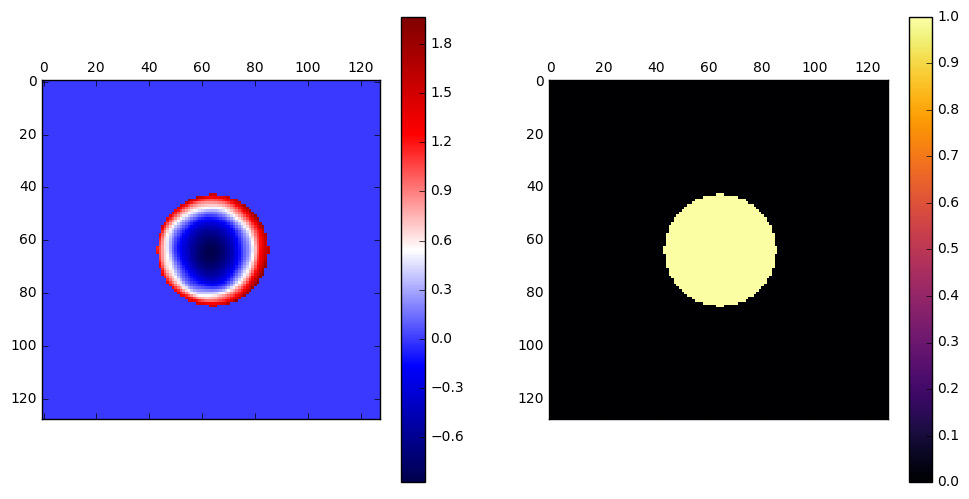

In [55]:
result2 = retrieve_phase2(junk, params, 25, phase_only=True)
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(result2.phase, cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(result2.mag, cmap="inferno")
colorbar(img2, ax=axs[1])
len(result2.pupil_diff)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:03<00:00,  8.24it/s]


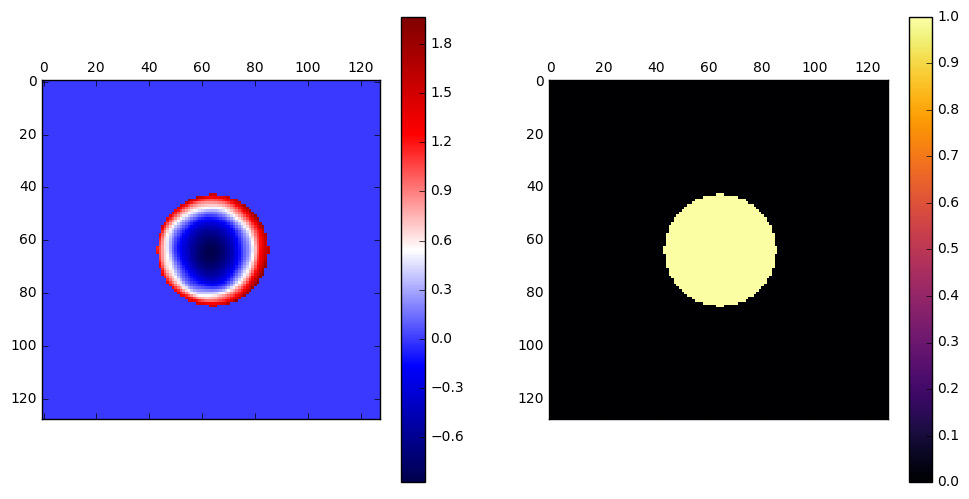

In [46]:
mag = psqrt(junk)
psf = HanserPSF(**params)
psf._gen_kr()
pupil = psf._gen_pupil()
for _ in tqdm.tqdm(range(25)):
    pupil, pupils = retrieve_phase_iter(mag, psf, pupil)
    pupil = exp(1j * angle(pupil)) * psf._gen_pupil().real
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow((ifftshift(angle(pupil))) * ifftshift(psf._gen_pupil().real), cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(ifftshift(abs(pupil)), cmap="inferno")
colorbar(img2, ax=axs[1])

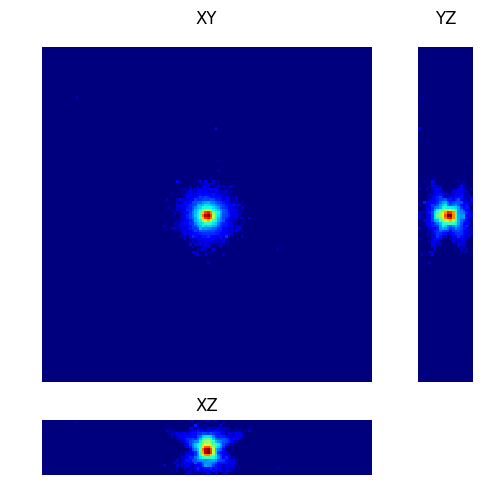

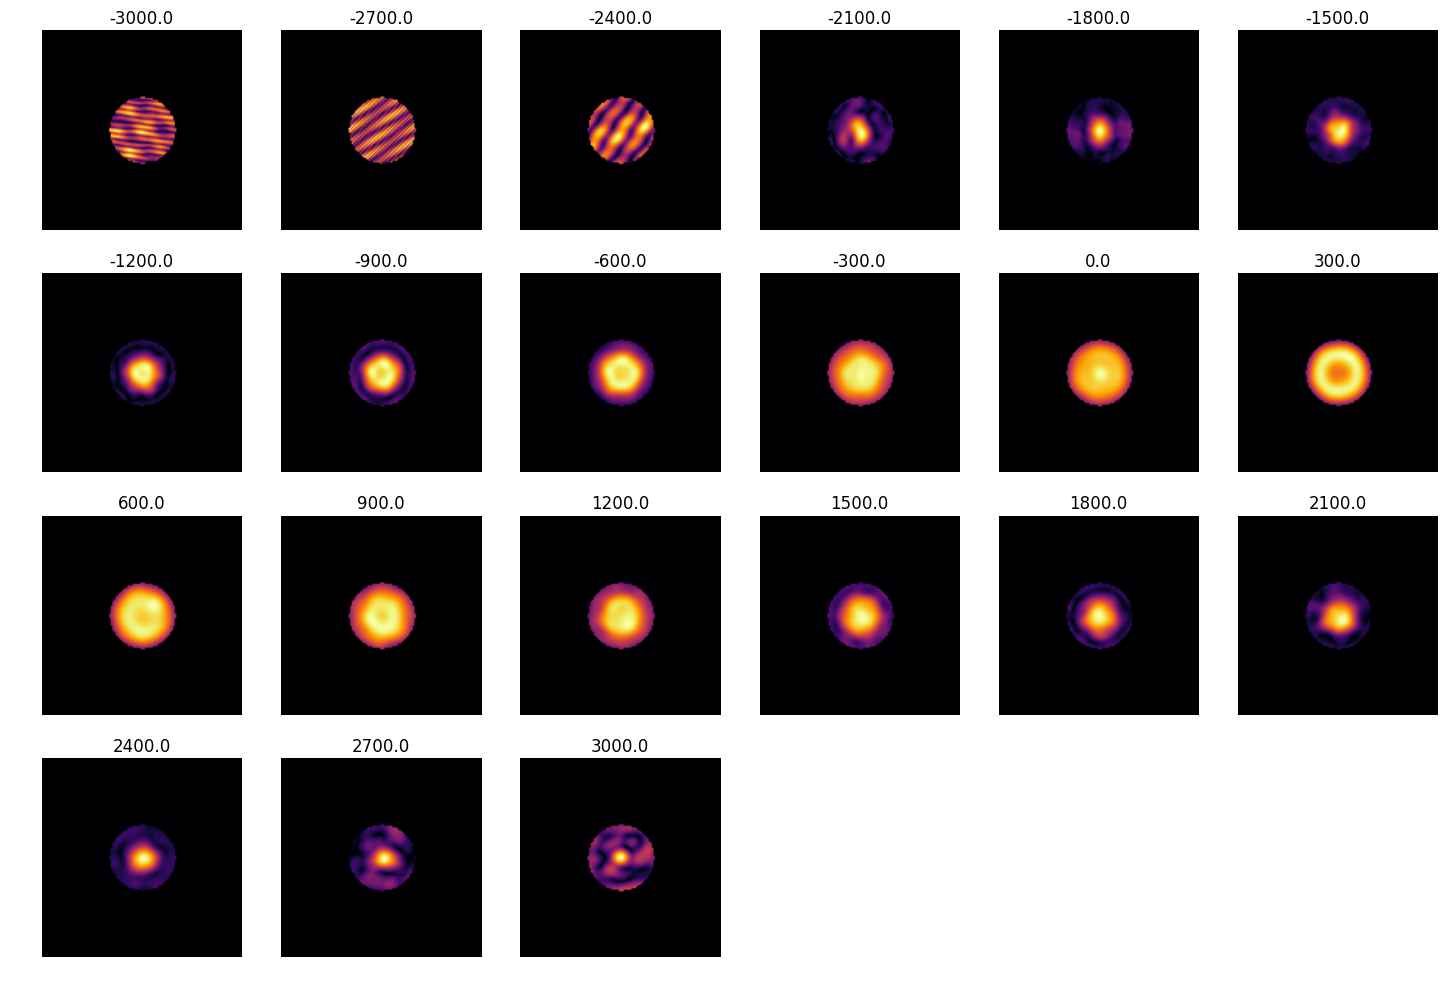

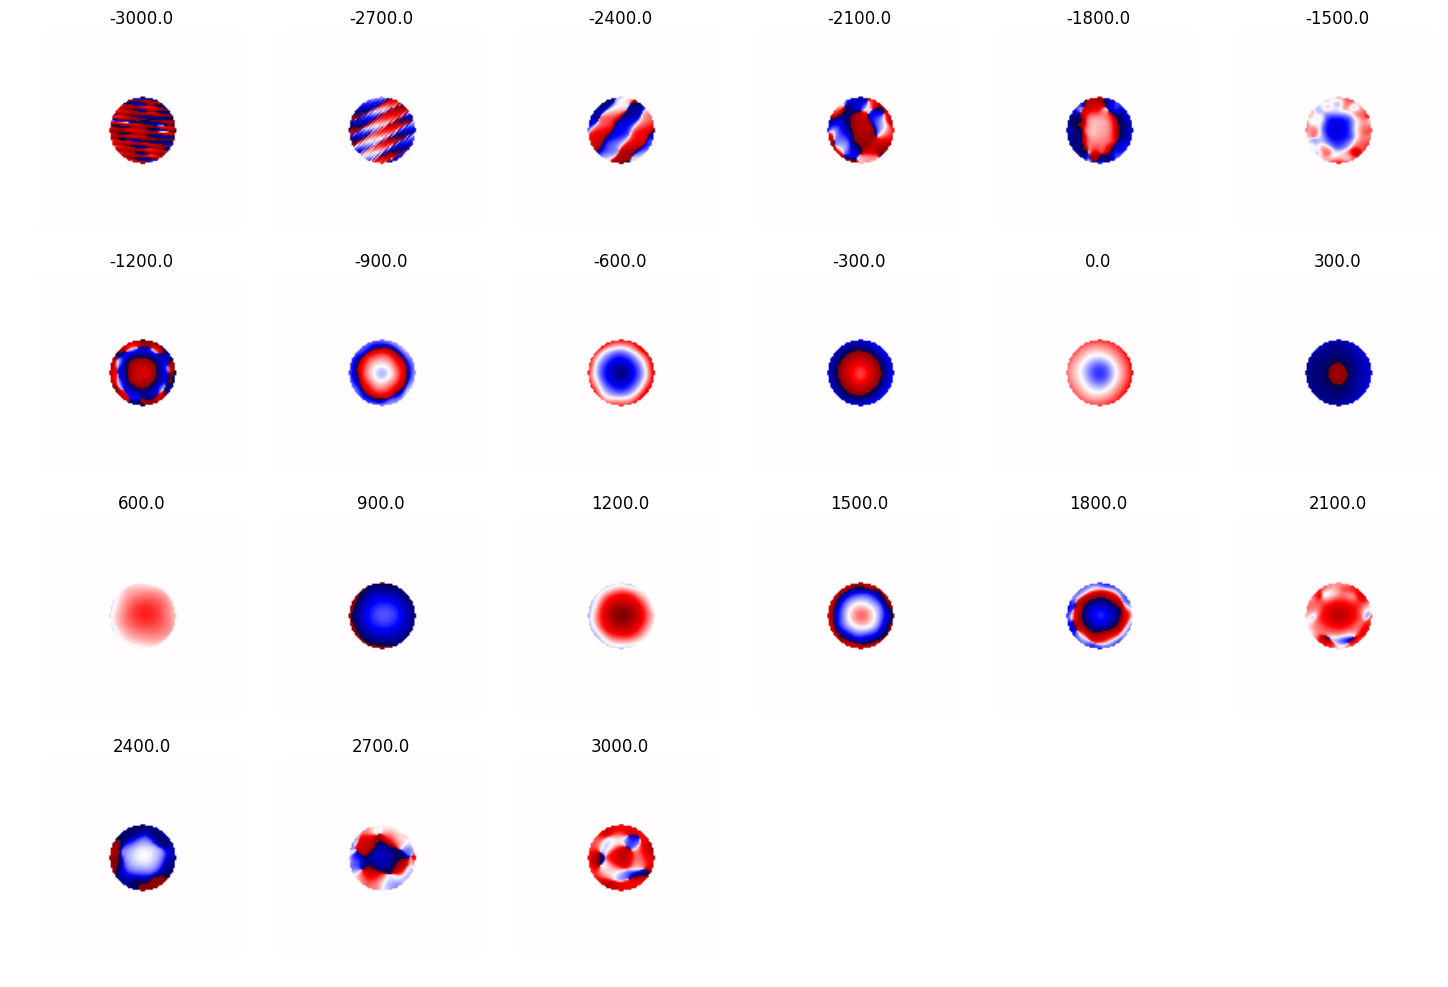

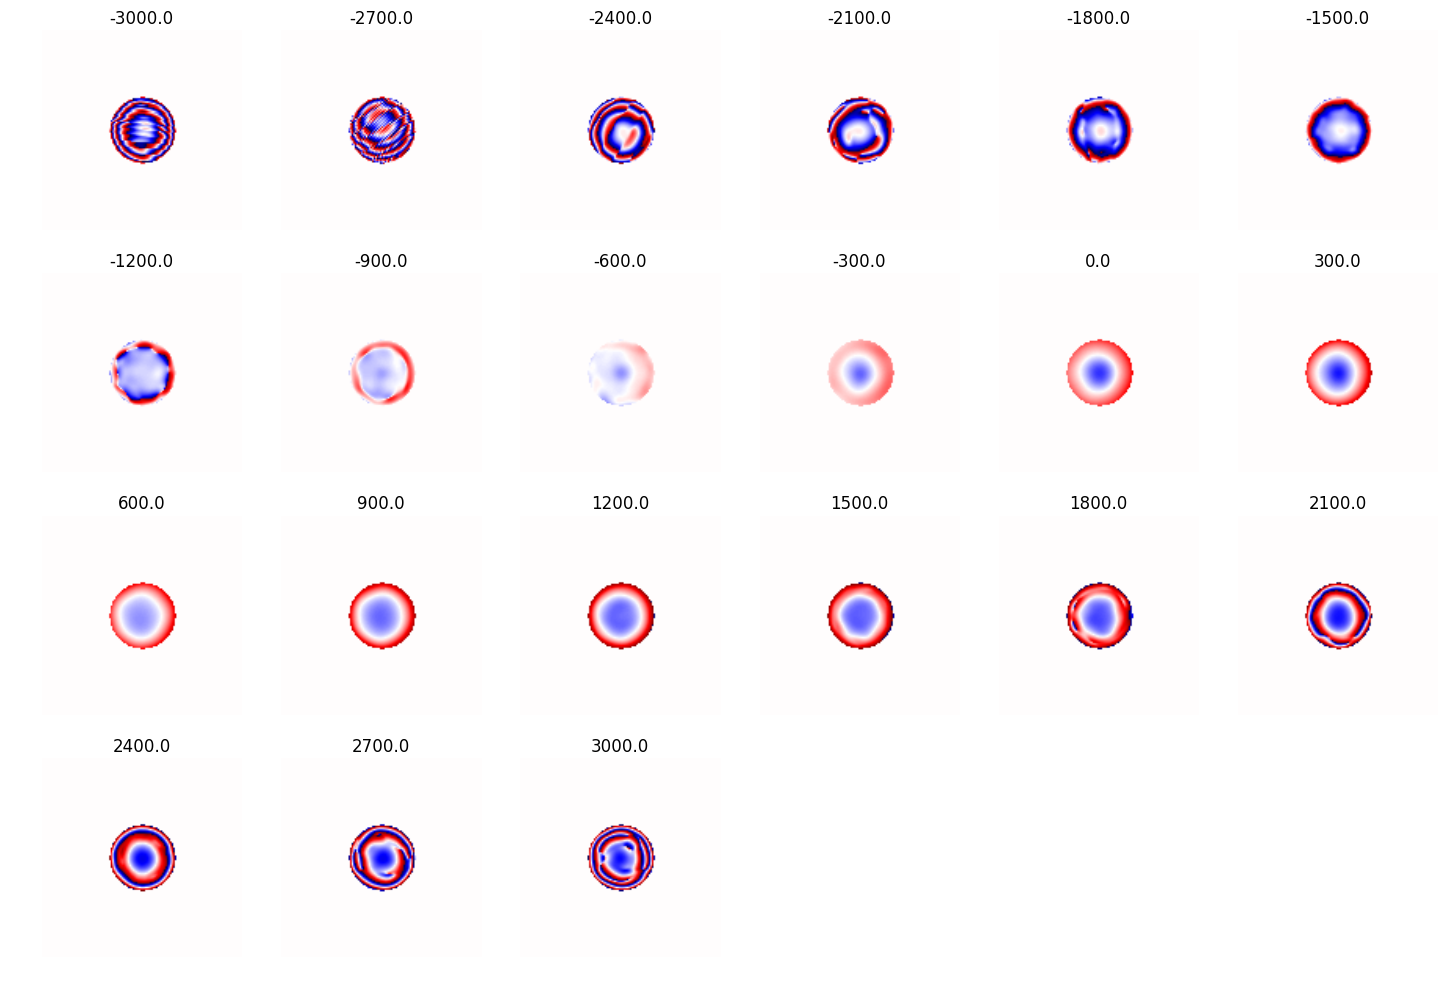

In [13]:
mip(mag)

display_grid({z:ifftshift(abs(pupil) * psf._gen_pupil().real)
              for z, pupil in zip(psf.zrange, pupils / psf._calc_defocus())},
            cmap="inferno");

display_grid({z:ifftshift(angle(pupil) * psf._gen_pupil().real)
              for z, pupil in zip(psf.zrange, pupils)}, vmin=-pi, vmax=pi, cmap="seismic");

display_grid({z:ifftshift(angle(pupil) * psf._gen_pupil().real)
              for z, pupil in zip(psf.zrange, pupils/psf._calc_defocus())},
             vmin=-pi, vmax=pi, cmap="seismic");

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:30<00:00,  8.17it/s]


{'condition': 'none',
 'na': 1.1,
 'ni': 1.33,
 'res': 90.5,
 'size': 128,
 'vec_corr': 'none',
 'wl': 605,
 'zres': 300,
 'zsize': 21}

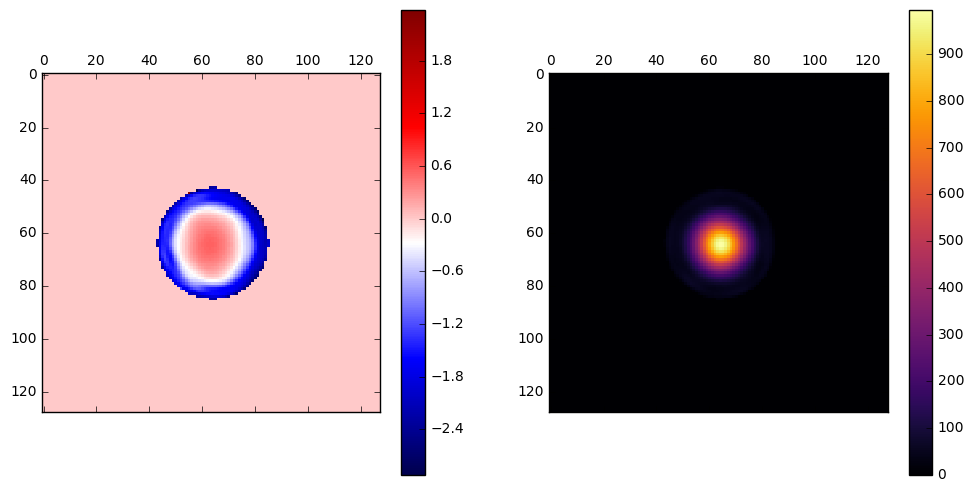

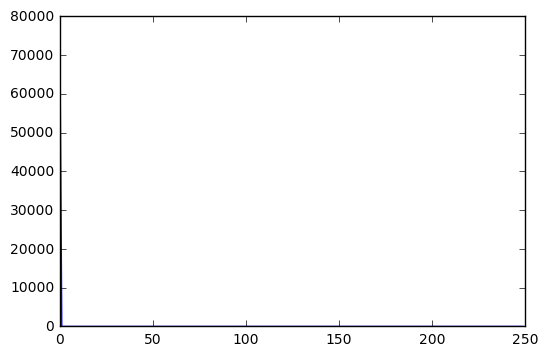

In [62]:
psf = HanserPSF(**params)
psf._gen_kr()
old_pupil2 = psf._gen_pupil()
mse2 = []
for _ in tqdm.tqdm(range(250)):
    pupil2, pupils2 = retrieve_phase_iter(mag, psf, old_pupil2, False)
    psf._PSFi = None
    mse2.append((abs(pupil2 - old_pupil2)**2).sum()/(abs(old_pupil2)**2).sum())
    old_pupil2 = pupil2
fig, axs = subplots(1, 2, figsize = (12, 6))
img1 = axs[0].matshow(ifftshift(angle(conj(pupil2)) * psf._gen_pupil().real), cmap="seismic")
colorbar(img1, ax=axs[0])
img2 = axs[1].matshow(ifftshift(abs(pupil2)), cmap="inferno")
colorbar(img2, ax=axs[1])
figure()
plot(mse2)
params

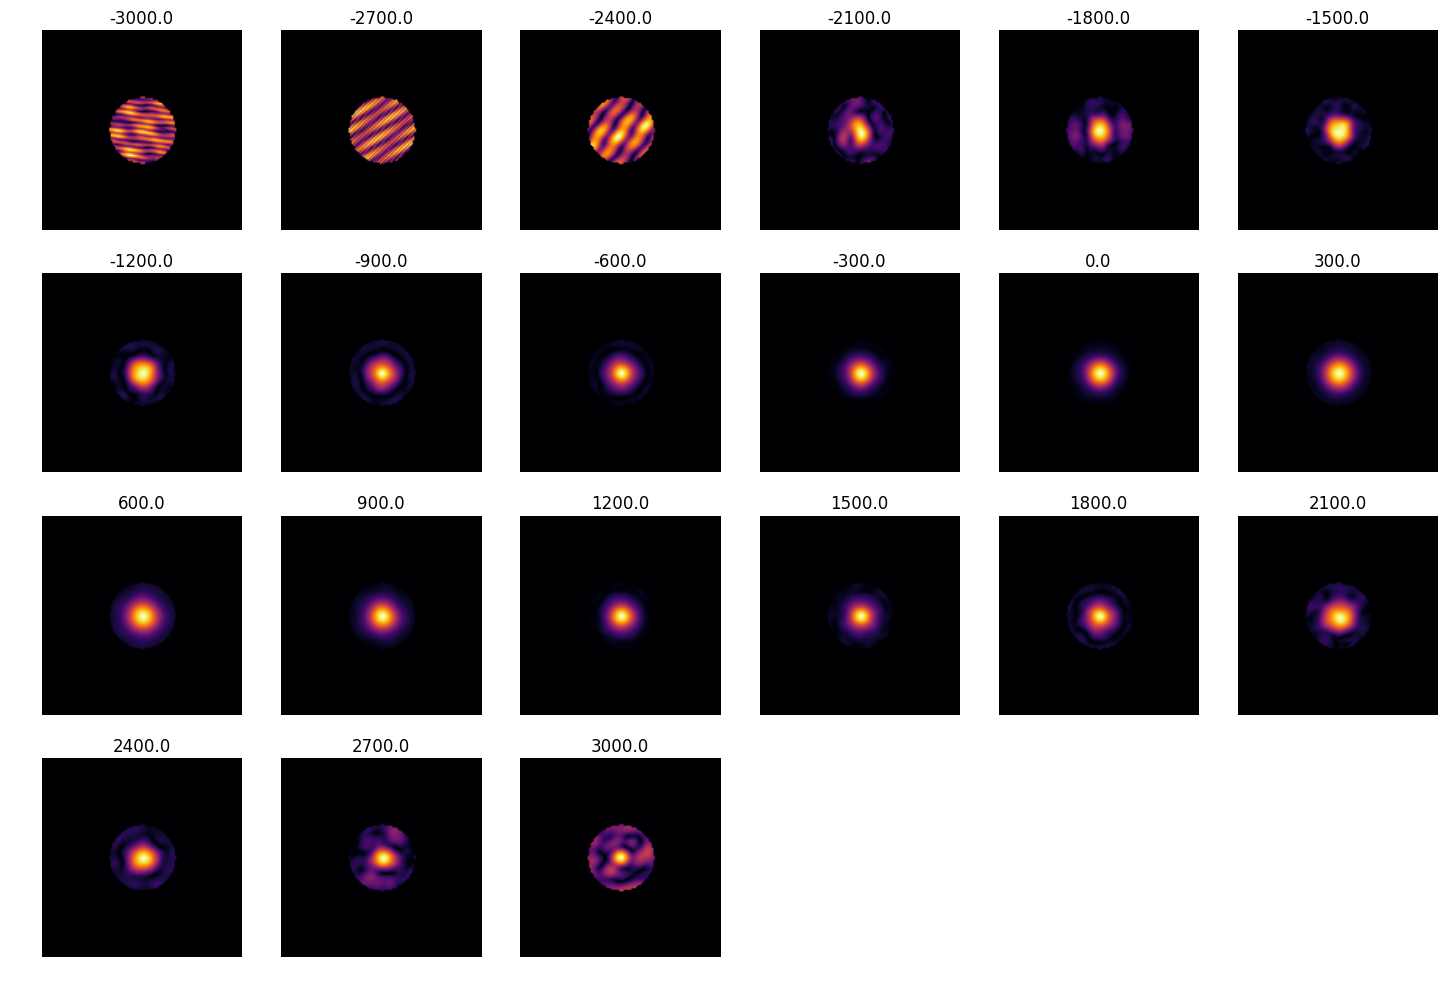

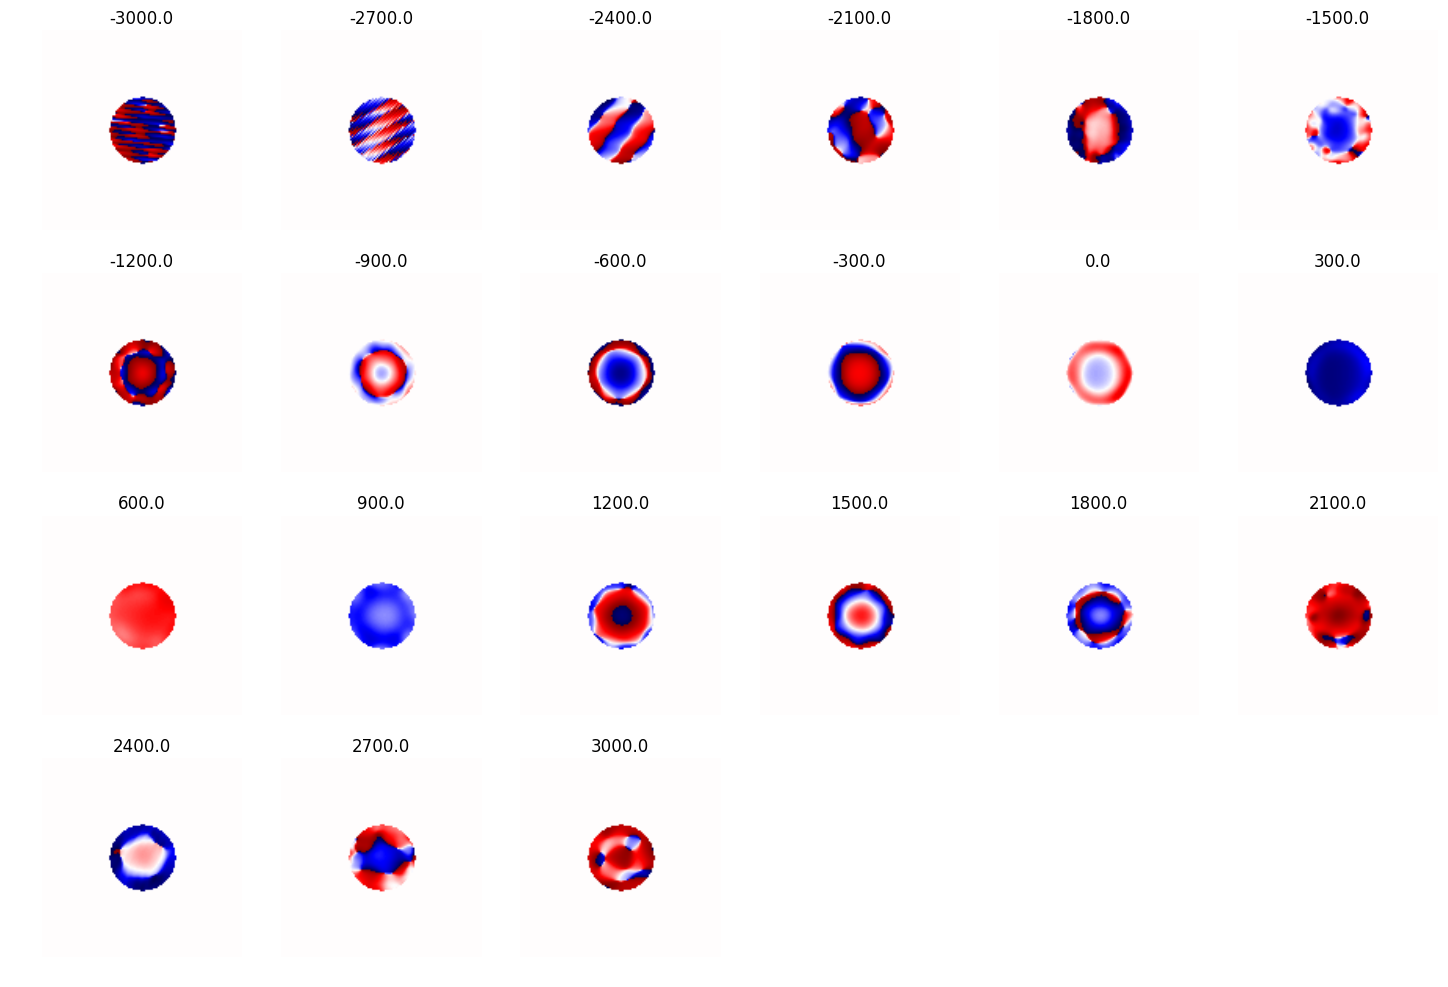

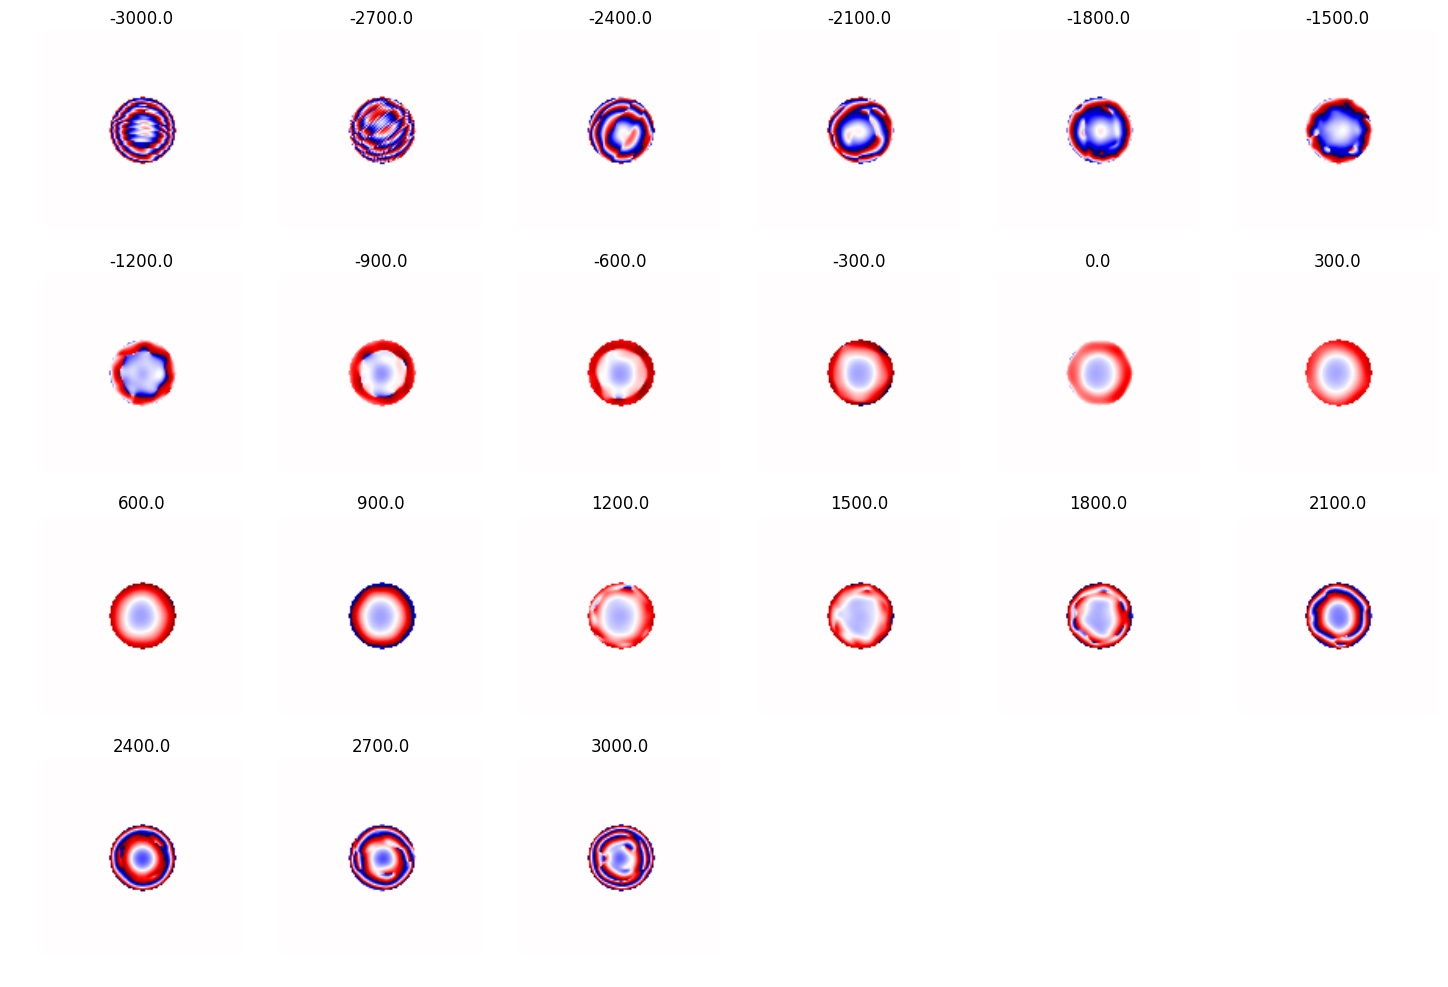

In [15]:
display_grid({z:ifftshift(abs(pupil2) * psf._gen_pupil().real)
              for z, pupil2 in zip(psf.zrange, pupils2 / psf._calc_defocus())},
            cmap="inferno");

display_grid({z:ifftshift(angle(pupil2) * psf._gen_pupil().real)
              for z, pupil2 in zip(psf.zrange, pupils2)}, vmin=-pi, vmax=pi, cmap="seismic");

display_grid({z:ifftshift(angle(pupil2) * psf._gen_pupil().real)
              for z, pupil2 in zip(psf.zrange, pupils2/psf._calc_defocus())},
             vmin=-pi, vmax=pi, cmap="seismic");

(<matplotlib.figure.Figure at 0x1b630aa0f60>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B63158FE80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001B6319821D0>], dtype=object))

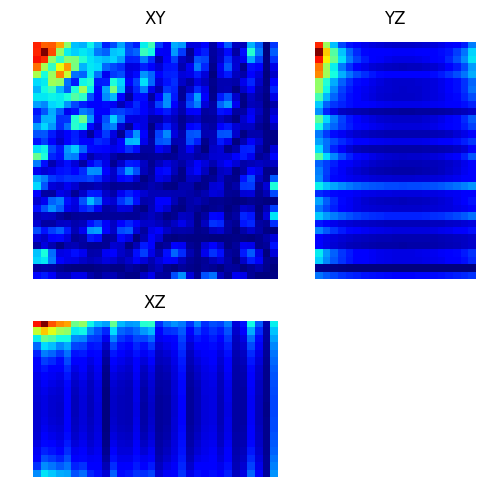

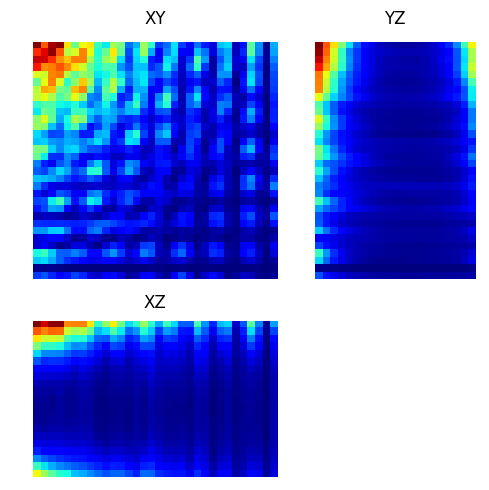

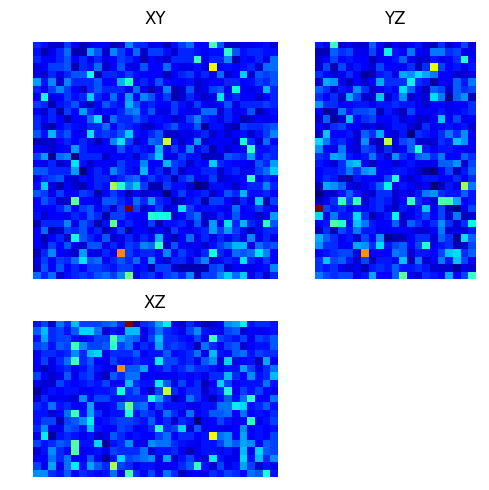

In [16]:
psf._gen_psf(pupil)
psf._PSFi=None
nx = test_data.shape
mip(psf.PSFi[[Ellipsis] + [slice(nx-32, nx+32)]*2])
psf._gen_psf(pupil2)
psf._PSFi=None
mip(psf.PSFi[[Ellipsis] + [slice(nx-32, nx+32)]*2])
mip(test_data[[Ellipsis] + [slice(nx-32, nx+32)]*2])

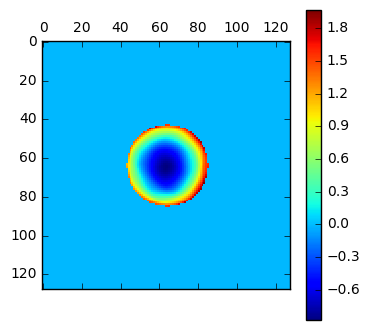

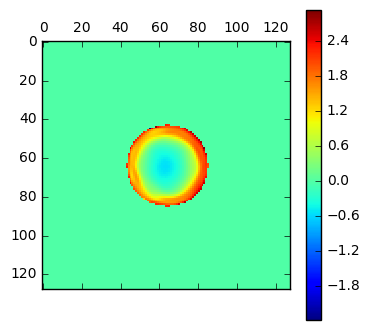

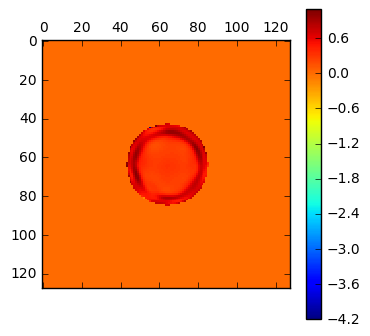

In [17]:
matshow(ifftshift(psf._gen_pupil().real) * (ifftshift(angle(pupil))))
colorbar()
matshow(ifftshift(psf._gen_pupil().real) * (ifftshift(angle(pupil2))))
colorbar()
matshow(ifftshift(psf._gen_pupil().real) * (ifftshift(angle(pupil2)-angle(pupil))))
colorbar()

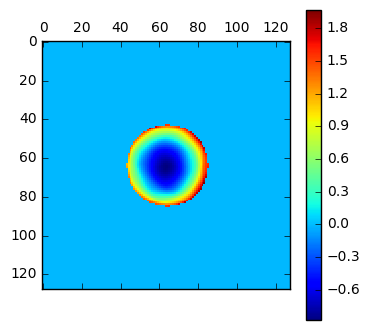

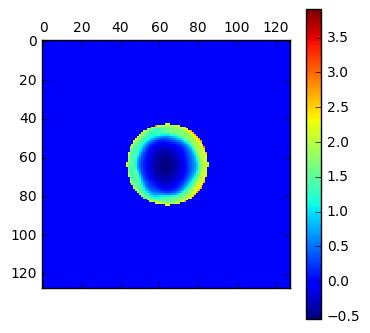

In [18]:
matshow(ifftshift(psf._gen_pupil().real) * unwrap_phase(ifftshift(angle(pupil))))
colorbar()
matshow(ifftshift(psf._gen_pupil().real) * unwrap_phase(ifftshift(angle(pupil2))))
colorbar()

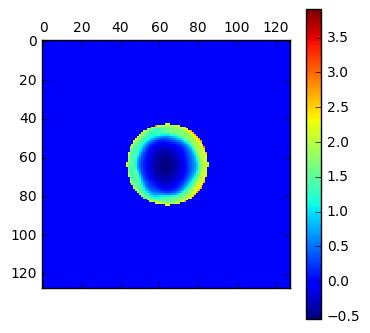

In [19]:
matshow(ifftshift(psf._gen_pupil().real) * unwrap_phase(ifftshift(angle(pupil2))))
colorbar()

(<matplotlib.figure.Figure at 0x1b631f2a710>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6322FEEF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001B63205F160>], dtype=object))

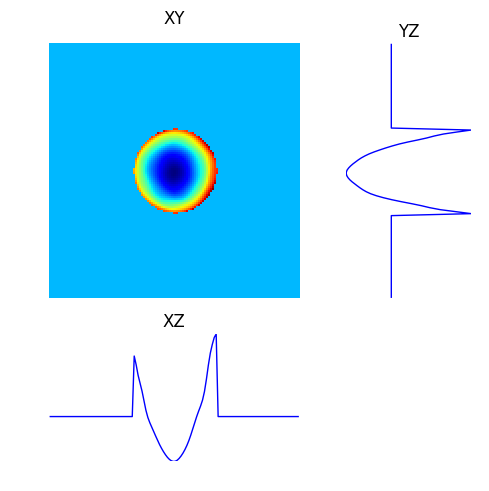

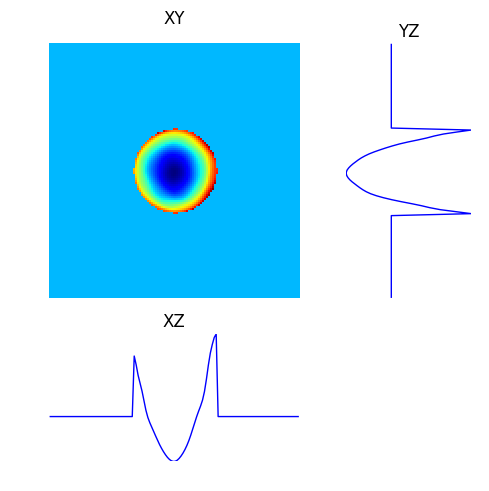

In [20]:
unwrapped = ifftshift(psf._gen_pupil().real) * unwrap_phase(ifftshift(angle(pupil)))
original = ifftshift(psf._gen_pupil().real) * (ifftshift(angle(pupil)))
slice_plot(unwrapped)
slice_plot(original)

(<matplotlib.figure.Figure at 0x1b6317a8358>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B631D01CC0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001B6323D2BE0>], dtype=object))

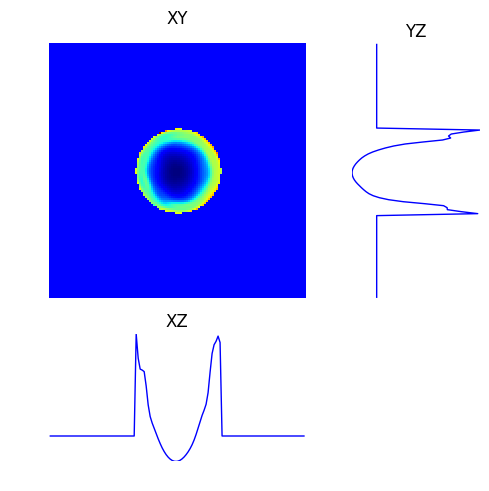

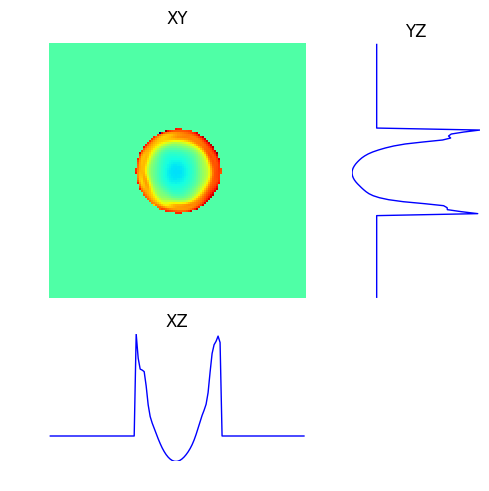

In [21]:
unwrapped = ifftshift(psf._gen_pupil().real) * unwrap_phase(ifftshift(angle(pupil2)))
original = ifftshift(psf._gen_pupil().real) * (ifftshift(angle(pupil2)))
slice_plot(unwrapped)
slice_plot(original)

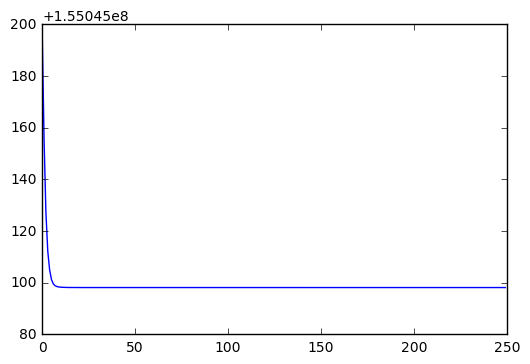

In [42]:
plot(mse[:])

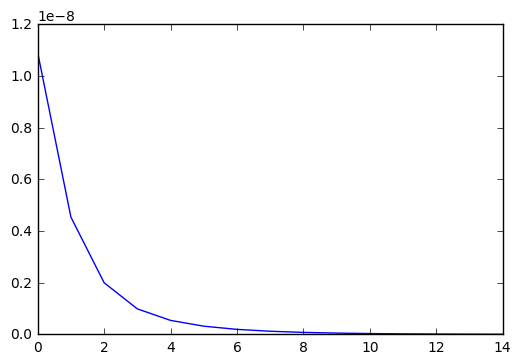

In [49]:
plot(((array(mse)[:-1] - array(mse)[1:])/array(mse)[:-1])[5:20])

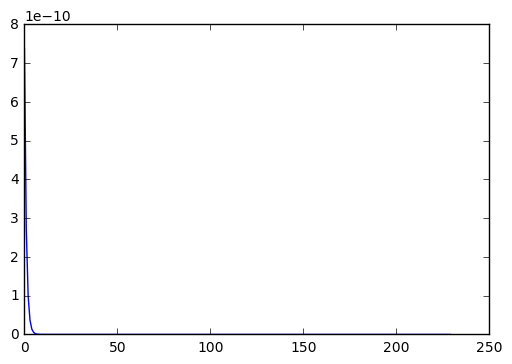

In [65]:
plot(mse2[20:])

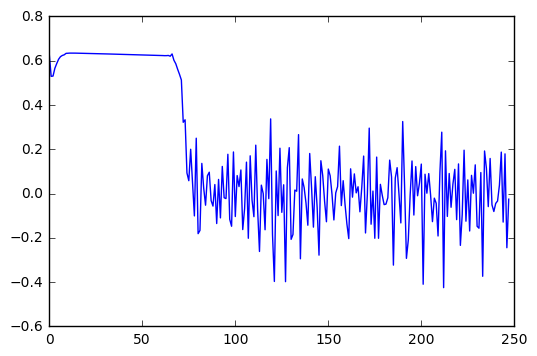

In [54]:
plot(((array(mse2)[:-1] - array(mse2)[1:])/array(mse2)[:-1])[1:])